# IHLT Lab 7: Word Sequences

**Author:** *Zachary Parent ([zachary.parent](mailto:zachary.parent@estudiantat.upc.edu))*

### 2024-10-31

**Instructions:**

1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.

2. Compute their similarities by considering the following approach:

3. words plus NEs and Jaccard coefficient
    * ex: word_and_NEs=['John Smith', 'is', 'working']
        Show the results.

4. Do you think it could be relevant to use NEs to compute the similarity between two sentences? Justify the answer.


## Setup

In [1]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from nltk.metrics.distance import jaccard_distance
import spacy
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from textserver import TextServer
import config

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package words is already up-to-date!


### 1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.

In [3]:
BASE_PATH = "./"

In [4]:
assert BASE_PATH is not None, "BASE_PATH is not set"

## Load the data

In [5]:
dt = pd.read_csv(
    f"{BASE_PATH}/test-gold/STS.input.SMTeuroparl.txt", sep="\t", header=None
)
dt.columns = ["s1", "s2"]
gs = pd.read_csv(f"{BASE_PATH}/test-gold/STS.gs.SMTeuroparl.txt", sep="\t", header=None)
dt["gs"] = gs[0]
dt.head()

,s1,s2,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


## Previous results

In [6]:
# Lemmatization methods using spaCy
def lemmatize_word(word):
    doc = nlp(word)
    return doc[0].lemma_

def lemmatize_tokens(tokens):
    return [token.lemma_ for token in tokens]

In [7]:
# Token pre-processing methods
def sentence_to_doc(sentence):
    return nlp(sentence)

def get_token_text(doc_or_tokens):
    return [token.text for token in doc_or_tokens]

def remove_non_alnum(words : list[str]):
    return [word for word in words if word.isalnum()]

def lower(words : list[str]):
    return [word.lower() for word in words]

def remove_stopwords(doc_or_tokens):
    return [token for token in doc_or_tokens if not token.is_stop]

In [8]:
s1_docs = dt["s1"].apply(nlp)
s1_without_stopwords = s1_docs.apply(remove_stopwords)
s1_lemmas = s1_without_stopwords.apply(lemmatize_tokens)
s1_lowered = s1_lemmas.apply(lower)
s1_without_non_alnum = s1_lowered.apply(remove_non_alnum)

print(f"{s1_without_non_alnum.iloc[0]} \n{s1_lowered.iloc[0]}")



['leader', 'give', 'new', 'chance', 'let', 'hope', 'seize'] 
['leader', 'give', 'new', 'chance', 'let', 'hope', 'seize', '.']


In [9]:
# Scoring methods
def jaccard_vector(s1, s2):
    return pd.concat([s1, s2], axis=1).apply(
        lambda x: jaccard_distance(set(x.iloc[0]), set(x.iloc[1])), axis=1
    )


def score_jaccard_vector(jaccard_vector, gold_standard=gs):
    return pearsonr(gold_standard[0], jaccard_vector)[0]

In [10]:
def apply_steps(s1_values, s2_values, steps):
    results = pd.DataFrame(index=["score"])
    for i in range(len(steps)):
        s1_values = s1_values.apply(steps[i])
        s2_values = s2_values.apply(steps[i])
        if s1_values[0].__class__ != list or s1_values[0][0].__class__ != str:
            s1_tokens = s1_values.apply(get_token_text)
            s2_tokens = s2_values.apply(get_token_text)
        else:
            s1_tokens = s1_values
            s2_tokens = s2_values

        results[steps[i].__name__] = score_jaccard_vector(jaccard_vector(s1_tokens, s2_tokens))
    return results

In [11]:
steps = [
    sentence_to_doc,
    remove_stopwords,
    lemmatize_tokens,
    lower,
    remove_non_alnum
]

previous_results = apply_steps(dt["s1"], dt["s2"], steps)
previous_results.head()

,sentence_to_doc,remove_stopwords,lemmatize_tokens,lower,remove_non_alnum
score,-0.460603,-0.468166,-0.489411,-0.495948,-0.539914


### 2. Apply Word Sequence algorithms to the words in the sentences.

In [10]:
def prepend_nltk_NEs(tokens):
    ne_list =  nltk.ne_chunk(nltk.pos_tag(tokens))
    return ['.'.join([ne[0][0], ne.label()]) if hasattr(ne, "label") else ne[0] for ne in ne_list]

In [11]:
res = prepend_nltk_NEs(s1_tokens.iloc[0])
print(res)
print(s1_tokens.iloc[0])


['the', 'leaders', 'have', 'now', 'been', 'given', 'a', 'new', 'chance', 'and', 'let', 'us', 'hope', 'they', 'seize', 'it']
['the', 'leaders', 'have', 'now', 'been', 'given', 'a', 'new', 'chance', 'and', 'let', 'us', 'hope', 'they', 'seize', 'it']


In [12]:
res = prepend_nltk_NEs(nltk.word_tokenize("Mark Pedersen is working at Google since 1994."))
i = 7
print(res[i])

1994


In [13]:
def substitute_spacy_NEs(tokens):
    doc = nlp(' '.join(tokens))
    with doc.retokenize() as retokenizer:
        tokens = [token for token in doc]
        for ent in doc.ents:
            retokenizer.merge(doc[ent.start:ent.end], 
                attrs={"LEMMA": " ".join([tokens[i].text 
                                    for i in range(ent.start, ent.end)])})
    return [token.text for token in doc]

In [14]:
substitute_spacy_NEs("Mark Pedersen is working at Google since 1994.".split())

['Mark Pedersen', 'is', 'working', 'at', 'Google', 'since', '1994', '.']

In [15]:
substitute_spacy_NEs(s1_tokens.iloc[18])

['mr',
 'president',
 'the',
 'cashman',
 'report',
 'can',
 'be',
 'summarised',
 'in',
 'four',
 'words',
 'citizens',
 'power',
 'over',
 'bureaucracy']

In [47]:
s1_with_nltk_NEs = s1_lemmas.apply(prepend_nltk_NEs)
s2_with_nltk_NEs = s2_lemmas.apply(prepend_nltk_NEs)
results["with_nltk_NEs"] = score_jaccard_vector(jaccard_vector(s1_with_nltk_NEs, s2_with_nltk_NEs))

s1_with_spacy_NEs = s1_lemmas.apply(substitute_spacy_NEs)
s2_with_spacy_NEs = s2_lemmas.apply(substitute_spacy_NEs)
results["with_spacy_NEs"] = score_jaccard_vector(jaccard_vector(s1_with_spacy_NEs, s2_with_spacy_NEs))

['mr',
 'president',
 'the',
 'cashman',
 'report',
 'can',
 'be',
 'summarised',
 'in',
 'four',
 'words',
 'citizens',
 'power',
 'over',
 'bureaucracy']

### 3. Compute their similarities by considering senses and Jaccard coefficient.

In [10]:
# TODO
results.head()

,tokenize,lemmatize
score,-0.490289,-0.503693


### 4. Results comparison

<Figure size 1000x600 with 0 Axes>

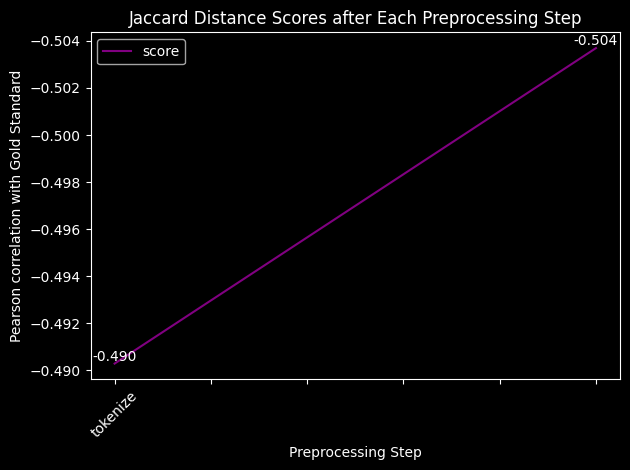

In [11]:
plt.figure(figsize=(10, 6))
results.T.plot(kind="line", color=["purple"])
plt.title("Jaccard Distance Scores after Each Preprocessing Step")
plt.xlabel("Preprocessing Step")
plt.ylabel("Pearson correlation with Gold Standard")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.tight_layout()

# Annotate chart values
for i, v in enumerate(results.values[0]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom", color="white")
plt.show()

As we can see above, the pipeline including lemmatization remains the best performing one. Adding sense disambiguation with either Lesk or UKB decreases the performance.

### 5. Leave-one-out analysis

In [12]:
leave_one_out_results = pd.DataFrame(index=["score"])

# Base tokenization (always included)
s1_tokens = dt["s1"].apply(nltk.word_tokenize)
s2_tokens = dt["s2"].apply(nltk.word_tokenize)

# Configuration 1: Skip lowercase
s1_config1 = (
    s1_tokens.apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
s2_config1 = (
    s2_tokens.apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
leave_one_out_results["skip_lowercase"] = score_jaccard_vector(
    jaccard_vector(s1_config1, s2_config1)
)

# Configuration 2: Skip remove non-alnum
s1_config2 = (
    s1_tokens.apply(lower)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
s2_config2 = (
    s2_tokens.apply(lower)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
leave_one_out_results["skip_remove_non_alnum"] = score_jaccard_vector(
    jaccard_vector(s1_config2, s2_config2)
)

# Configuration 3: Skip remove stopwords
s1_config3 = (
    s1_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(lemmatize_many)
)
s2_config3 = (
    s2_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(lemmatize_many)
)
leave_one_out_results["skip_remove_stopwords"] = score_jaccard_vector(
    jaccard_vector(s1_config3, s2_config3)
)

# Configuration 4: Skip lemmatize
s1_config4 = (
    s1_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
)
s2_config4 = (
    s2_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
)
leave_one_out_results["skip_lemmatize"] = score_jaccard_vector(
    jaccard_vector(s1_config4, s2_config4)
)

# TODO
# Configuration 5: Skip lesk
s1_config5 = (
    s1_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
s2_config5 = (
    s2_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
leave_one_out_results["skip_lesk"] = score_jaccard_vector(
    jaccard_vector(s1_config5, s2_config5)
)

# Add the full pipeline for comparison
s1_full = (
    s1_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
s2_full = (
    s2_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
leave_one_out_results["full_pipeline"] = score_jaccard_vector(
    jaccard_vector(s1_full, s2_full)
)

print(
    "\033[1mJaccard Distance Correlation with Gold Standard for different configurations:\033[0m"
)
print()
print(leave_one_out_results)

Jaccard Distance Correlation with Gold Standard for different configurations:

       skip_lowercase  skip_remove_non_alnum  skip_remove_stopwords  \
score       -0.471052              -0.465986              -0.495849   

       skip_lemmatize  skip_lesk  full_pipeline  
score       -0.480942  -0.503693      -0.503693  


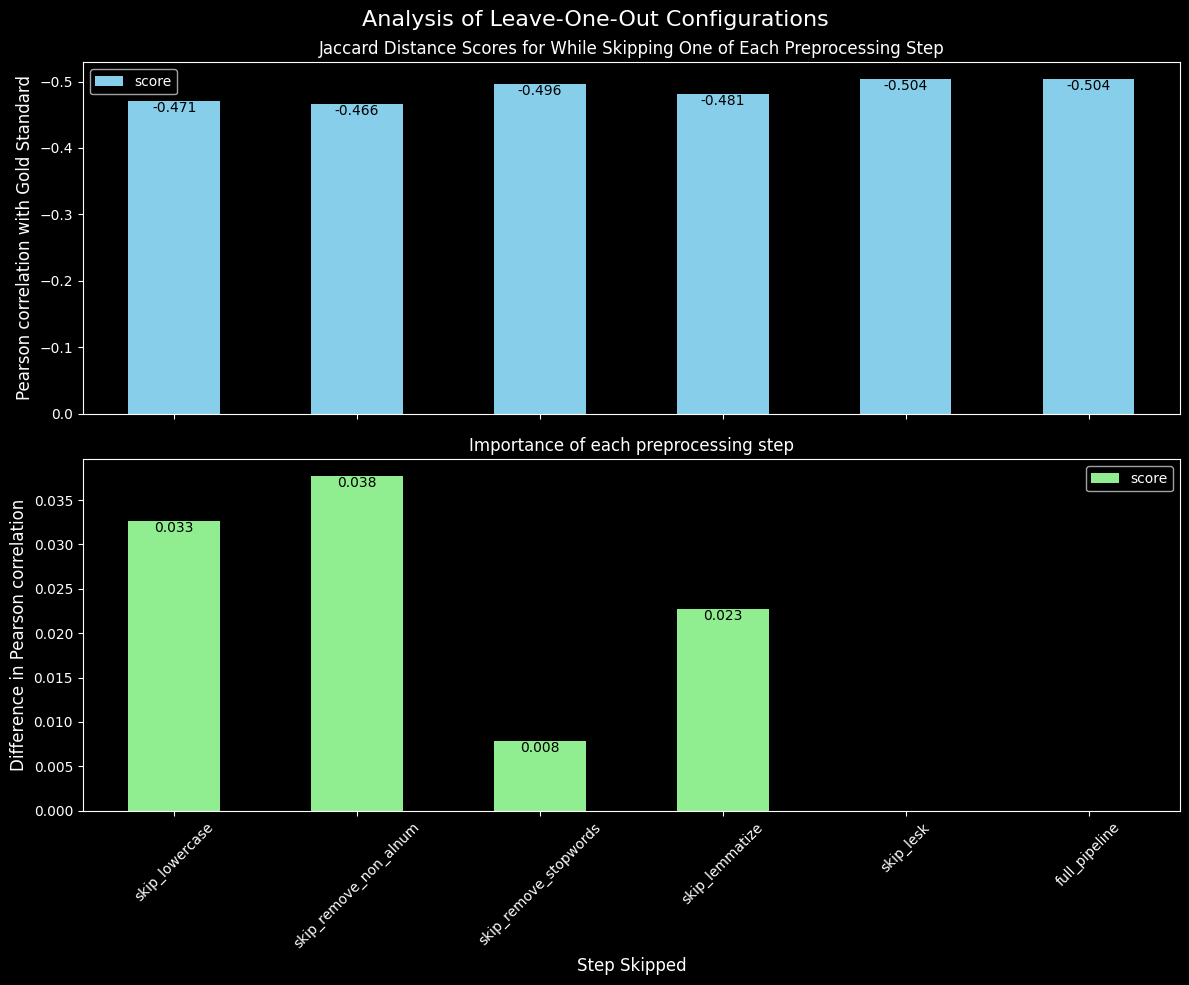

In [13]:
# Plot bar chart for leave-one-out results and differences from full pipeline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

fig.suptitle("Analysis of Leave-One-Out Configurations", fontsize=16)

# Original bar chart
leave_one_out_results.T.plot(kind="bar", color=["skyblue"], ax=ax1)
ax1.set_title(
    "Jaccard Distance Scores for While Skipping One of Each Preprocessing Step"
)
ax1.set_ylabel("Pearson correlation with Gold Standard", fontsize=12)
ax1.invert_yaxis()


# Annotate original bar chart values
for i, v in enumerate(leave_one_out_results.values[0]):
    ax1.text(i, v, f"{v:.3f}", ha="center", va="top", color="black")

# Calculate and plot differences from full pipeline
full_pipeline_score = leave_one_out_results["full_pipeline"].values[0]
differences = leave_one_out_results.subtract(full_pipeline_score).T
differences.plot(kind="bar", color=["lightgreen"], ax=ax2)
ax2.set_title("Importance of each preprocessing step")
ax2.set_xlabel("Step Skipped", fontsize=12)
ax2.set_ylabel("Difference in Pearson correlation", fontsize=12)
ax2.tick_params(axis="x", rotation=45)

# Annotate difference bar chart values
ax2.axhline(0, color="white", linewidth=0.5)
for i, v in enumerate(differences.values):
    ax2.text(
        i,
        v,
        f"{v[0]:.3f}",
        ha="center",
        va="top" if v[0] > 0 else "bottom",
        color="black",
    )

plt.tight_layout()
plt.show()

Above, we compare the full pipeline, including lemmatization and sense disambiguation via lesk, with the results of skipping each preprocessing step. We can see that skipping stopword removal is the most detrimental, and skipping sense disambiguation is the least detrimental. In fact, skipping lesk improves the results.

# Analysis & Conclusions




### Key Results

In this lab we have continued our work of trying to improve the performance of our similarity analysis between sentences. We have explored the use of word sense disambiguation (WSD) to improve the performance of our metric.

As previously found, simple tokenization yielded a pearson similarity between our jaccard distance scores and the gold standard of `~0.490`. Using lemmatization has also improved the results to `~0.504`. Adding a word sense disambiguation step with Lesk decreased the performance to `~0.500`, and with UKB it was even worse with a score of `~0.493`.

### Lesk vs UKB

We were surprised to find UKB performing worse than Lesk. We hypothesize that this is because UKB is more sensitive to the context of the word, yielding more specific and typically more useful synsets. In contrast, Lesk yields more general synsets, which are more likely to be a good match for the words in the sentences.

### Leave-one-out analysis

We employed the use of leave-one-out analysis to understand the importance of each preprocessing step. We discovered that word sense disambiguation does not improve the performance of our metric, and in fact, skipping it slightly improves the results. This is most likely because the sense disambiguation is sensitive and can lead to very different results in each sentence. In addition, it doesn't help much with softening synonyms, which is something synsets are generally useful for.

Our best performing pipeline is still tokenization, lowercasing, removing non-alphanumeric characters, removing stopwords, and lemmatization, yielding a pearson correlation of `~0.504` with the gold standard.

### Future work

Perhaps in the future we could explore the use of hypernyms from the detected synsets to generalize meaning across synonyms in the 2 sentences.